## Unsupervised learning on comment text distributions

In this notebook we will combine the parsed comment text from the training and test sets to do unsupervised learning like word2vec embeddings and topic models. Because we are not using the labels, it is fine to use the test data here and should be beneficial, as the test data is more than twice as large as the training data.

In [1]:
import numpy as np
import pandas as pd
import re
import copy
import gensim
from gensim.models import FastText

In [2]:
from sklearn import decomposition, preprocessing
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.externals import joblib

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

np.set_printoptions(precision=6,suppress=True)

### Read in training data and parse comments

In [4]:
full_train = pd.read_csv('../train.csv')
full_train.shape

(95851, 8)

In [5]:
comments=full_train['comment_text'].tolist()
tokenized_comments = copy.copy(comments)
clean_comments = []
token_dict = {}
token_set = set()
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    clean_comments.append(tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    for token in tokenized_comments[i]:        
        if token in token_set:
            token_dict[token] += 1
        else:
            token_set.add(token)
            token_dict[token] = 1    

### Read in test data and parse comments

In [6]:
testdat = pd.read_csv('../test.csv')
print(testdat.shape)

(226998, 2)


In [7]:
test_comments0 = testdat['comment_text'].tolist()
test_comments = copy.copy(test_comments0)
test_clean_comments = []
for i in range(len(test_comments)):
    if type(test_comments[i]) is float:
        print(i,test_comments[i])
        test_comments[i]=[]
        test_clean_comments.append('')
    else:
        test_comments[i] = re.sub("\n",' ',test_comments[i])
        test_comments[i] = re.sub("\t",' ',test_comments[i])
        test_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',test_comments[i])
        test_comments[i] = re.sub(" +",' ',test_comments[i])
        test_comments[i] = re.sub("'+","'",test_comments[i])    
        test_comments[i] = re.sub("\*+","\*",test_comments[i])   
        test_comments[i] = re.sub("\-+","\-",test_comments[i])
        test_comments[i] = test_comments[i].lower().strip()
        test_clean_comments.append(test_comments[i])
        test_comments[i] = test_comments[i].split(' ')
        for token in test_comments[i]:        
            if token in token_set:
                token_dict[token] += 1
            else:
                token_set.add(token)
                token_dict[token] = 1           

52300 nan


### Word frequency checks

In [8]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']

token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
token_count = token_count.reset_index()    

In [9]:
print(token_count['token'].head(80).tolist())

['the', 'to', 'of', 'and', 'a', 'you', 'link', 'is', 'i', 'wiki', 'that', 'in', 'it', 'for', 'wikipedia', 'this', 'on', 'not', 'be', 'as', 'if', 'have', 'are', 'your', 'or', 'article', 'with', 'page', 'was', 'an', 'but', 'by', 'please', 'from', 'at', 'my', 'do', '\\-', 'about', 'use', 'can', 'has', 'talk', 'any', 'image', 'will', 'would', 'there', 'so', 'been', 'one', 'edit', 'what', 'all', 'like', 'me', 'no', 'more', 'which', 'they', 'just', 'may', 'should', 'we', 'see', 'other', 'deletion', '\\*', 'articles', 'he', 'also', 'wp', 'some', 'here', "don't", 'think', 'hi', 'why', 'who', 'how']


In [10]:
# making a quick stopword list by frequency, excluding substantive words like "edit"
stopword_list = ['the', 'to', 'of', 'and', 'a', 'you','is', 'i','that', 'in', 'it', 'for',
                'this', 'on', 'not', 'be', 'as', 'if', 'have', 'are', 'your', 'or', 'with'
                ,'was', 'an', 'but', 'by', 'please', 'from', 'at', 'my', 'do', '\\-', 'about'
                , 'use', 'can', 'has', 'any',  'will', 'would', 'there']
len(stopword_list)

41

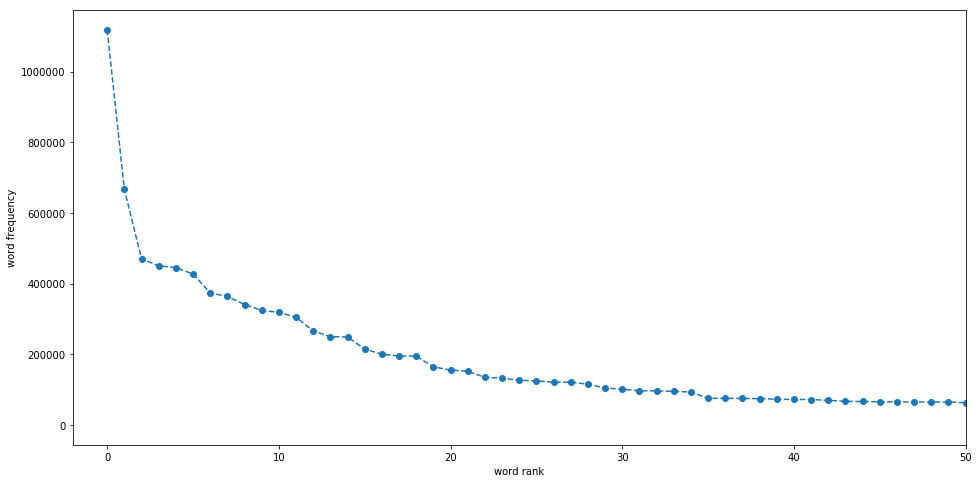

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(token_count['index'],token_count['freq'],linestyle='--', marker='o')
plt.xlim([-2,50])
plt.xlabel('word rank')
plt.ylabel('word frequency')

### Combine train and test comments

In [12]:
combined_comments = tokenized_comments + test_comments 
full_clean_comments = clean_comments + test_clean_comments
comment_ids = full_train["id"].tolist() + testdat["id"].tolist()
print(len(combined_comments))
print(len(full_clean_comments))
print(len(comment_ids))

322849
322849
322849


### Topic modeling via matrix factorization on TF-IDF 

In [34]:
# simple top words extraction from sklearn example
def print_top_words(model, feature_names, n_top_words):
    for topic_idx,topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [18]:
# convert token dictionaries into sparse matrix
v = CountVectorizer(stop_words=stopword_list,min_df=15)
v.fit(full_clean_comments)
X = v.transform(full_clean_comments)

In [19]:
# TF-IDF transformation on sparse matrix
tfidf = TfidfTransformer().fit_transform(X)
tfidf.shape

(322849, 25260)

In [29]:
# non-negative matrix factorization
nmf_fit = NMF(n_components=200).fit(X=tfidf)
nmf_fit.reconstruction_err_

481.9914951230972

In [32]:
joblib.dump(nmf_fit, '../nmf_model.pkl') 

['nmf_model.pkl']

In [35]:
feature_names = v.get_feature_names()
print_top_words(nmf_fit,feature_names,10)

Topic #0: wiki link special emailuser notability sandbox newcomers de john development
Topic #1: image png gif policy provided uploading description tagging days jpeg
Topic #2: because reason doesn didn wanted mean simply contested deleted cannot
Topic #3: speedy deletion criteria nominated tagged under questions contest csd criterion
Topic #4: constructive sandbox appear least test reverting although everyone such contributions
Topic #5: policy blocking editing disruptive blocked receive warning next accordance unjustified
Topic #6: summary introduction sandbox informative testing ensure wish unconstructive provide appears
Topic #7: pages hope place sign ask tutorial manual pillars five style
Topic #8: bot reverted repair apologies recognize humble attempts owner legitimate behavior
Topic #9: externa http www link org web html htm https id
Topic #10: talk contribs replied discuss email responded posts rfc talkback note
Topic #11: fair rationale explanation guideline questions disputed

In [36]:
nmf_topics = np.array(nmf_fit.transform(tfidf))

In [ ]:
np.corrcoef(x=nmf_topics[:,161],y=nmf_topics[:,38])

In [80]:
np.mean(nmf_topics[:,33]>0.001)

0.014564129249677867

(0, 0.01)

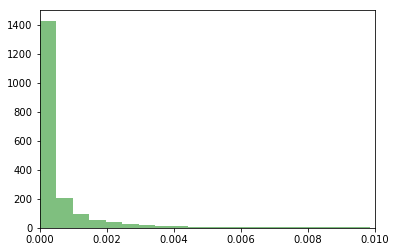

In [75]:
# plot zero histogram, excluding zeros
n, bins, patches = plt.hist(nmf_topics[nmf_topics[:,38]>0][:,38], 200, normed=1, facecolor='green', alpha=0.5)
plt.xlim([0,0.01])

In [48]:
# Save topic scores per comment
comment_topics = pd.DataFrame(nmf_topics).add_prefix("nmf_")
comment_topics['id'] = comment_ids
comment_topics.head()
comment_topics.to_csv("../comment_nmf_topics.csv",index=False)

### Word2Vec word embeddings

In [21]:
min_token_freq = 15
num_unique_tokens = token_count[token_count['freq']>=min_token_freq].shape[0]
print(num_unique_tokens)
print(num_unique_tokens/len(token_dict.keys()))
print(sum(token_count[token_count['freq']>=min_token_freq]['freq']/sum(token_count['freq'])))

31293
0.08671279452229405
0.969647020554


In [22]:
model = gensim.models.Word2Vec(size=50, window=7, min_count=15,iter=10,sg=1,workers=8)

In [23]:
model.build_vocab(combined_comments)
len(model.wv.vocab)

31293

In [24]:
model.train(combined_comments,total_examples=model.corpus_count,epochs=model.iter)

172819667

In [25]:
model.save("../wiki_comment_word2vec")

In [26]:
model.wv.most_similar(positive=['spam'])

[('spamming', 0.748274564743042),
 ('inappropriate', 0.747218906879425),
 ('spammer', 0.7094085812568665),
 ('linkfarm', 0.7023770809173584),
 ('self\\-promotion', 0.6910476684570312),
 ('promotion', 0.6873908638954163),
 ('misinformation', 0.6829708814620972),
 ('advertising', 0.6816965937614441),
 ('links', 0.6570734977722168),
 ('item', 0.655972421169281)]

In [27]:
model.wv.most_similar(positive=['sexist'])

[('homophobic', 0.8496531844139099),
 ('racist', 0.809245228767395),
 ('raving', 0.8077417016029358),
 ('misogynistic', 0.8000978827476501),
 ('slur', 0.7964104413986206),
 ('homophobe', 0.7958419322967529),
 ('stereotyping', 0.7799964547157288),
 ('slurs', 0.7624128460884094),
 ('amoral', 0.7623727321624756),
 ('ignorant', 0.7553340792655945)]

### Wider w2v vector

In [13]:
w2v_model_150dim = gensim.models.Word2Vec(size=150, window=7, min_count=15,iter=10,sg=1,workers=8)

In [18]:
w2v_model_150dim.build_vocab(combined_comments)
len(w2v_model_150dim.wv.vocab)

31293

In [20]:
w2v_model_150dim.train(combined_comments,total_examples=w2v_model_150dim.corpus_count,epochs=w2v_model_150dim.iter)

172816471

In [21]:
w2v_model_150dim.save("../wiki_comment_word2vec_150d")

### FastText embeddings

In [14]:
fasttext_model = FastText(combined_comments,sg=1,size=150,window=7,min_count=10,negative=7,workers=8)

In [16]:
fasttext_model.save("../wiki_fasttext_embed")

In [ ]:
fasttext_model.wv.most_similar(positive=['sexist'])